核心问题是如何有效估计 $P(x_t \mid x_{t-1},\ldots ,x_1)$

一般由有两种策略来解决这个问题

第一种是假设我们只需要某个长度为 $\tau$ 的时间跨度，也就是只需要 $x_{t-1}, \ldots, x_{t-\tau}$
这种称为是自回归模型，因为它们是对自己执行回归

第二种是保留一些对过去观测的总结 $h_t$（隐变量），并同时更新预测和总结 $h_t$
也就是基于 $\hat{x_t}=P(x_t \mid h_t)$ 估计$x_t$
这种模型称为是隐变量自回归模型

在自回归模型的近似法中，我们使用 $x_{t-1}, \ldots, x_{t-\tau}$来估计当前的x值，只要这种是近似精确的，我们就说序列满足马尔可夫条件

使用动态规划可以沿着马尔可夫链精确地计算结果
$$
\begin{align*}
P(x_{t+1} \mid x_{t-1}) &= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})} \\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})} \\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{align*}
$$

马尔可夫性质：允许我们将 $P(x_{t+1} \mid x_t,x_{t-1})$ 简化为 $P(x_{t+1} \mid x_t)$，即未来仅依赖于当前状态。
动态规划：通过引入中间状态$x_t$并边缘化，将多步转移分解为单步转移的组合。
短历史：计算时仅需要相邻时间步的转移概率，不需要更早的历史信息。

利用这一事实，我们只需考虑过去观察中一个非常短的历史即可


为了训练，首先生成一些序列数据，这里通过正弦函数和一些可加性噪声来生成

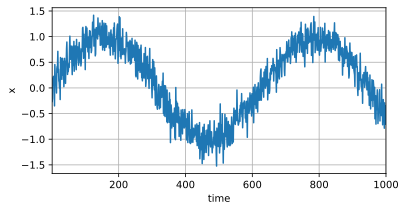

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

然后将这个序列转换为模型的特征-标签对

tau = 4 表示使用过去4个时间步的数据来预测下一个值，这体现了前面提到的自回归模型思想
features 初始化为大小为 (T-tau) × tau 的零矩阵，共有 T-tau 个样本，每个样本有 tau 个特征
循环填充特征矩阵:
features[:, 0] 存储 x[0] 到 x[T-5]
features[:, 1] 存储 x[1] 到 x[T-4]
features[:, 2] 存储 x[2] 到 x[T-3]
features[:, 3] 存储 x[3] 到 x[T-2]
labels 存储 x[4] 到 x[T-1]，即每个特征向量对应的下一个时间步的值

即使用过去固定长度τ的观测来预测当前值。

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

features形如：
行索引	第0列 (x[0:996])	第1列 (x[1:997])	第2列 (x[2:998])	第3列 (x[3:999])	对应预测目标
    0	0.1	                    0.2	                0.3	                0.4	                0.5
    1	0.2	                    0.3	                0.4	                0.5	                0.6
    2	0.3	                    0.4	                0.5	                0.6	                0.7
    3	0.4	                    0.5	                0.6	                0.7	                0.8
    4	0.5	                    0.6	                0.7	                0.8	                0.9
    5	0.6	                    0.7	                0.8	                0.9	                1.0

使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [4]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    # Adam（Adaptive Moment Estimation）是一种非常流行的优化算法，它结合了动量法和自适应学习率的优点

    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.069112
epoch 2, loss: 0.061013
epoch 3, loss: 0.060123
epoch 4, loss: 0.061760
epoch 5, loss: 0.058368


因为loss已经较小，因此进行预测

首先是检查模型预测下一个时间步的能力， 也就是单步预测

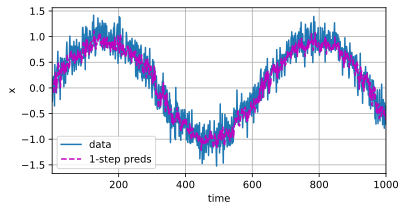

In [6]:
onestep_preds = net(features) # 生成预测值
# 每个预测是基于过去4个时间步(tau=4)的值，即所谓的"单步预测"

d2l.plot([time, time[tau:]],  # time: 原始数据的时间轴（1到1000） time[tau:]: 预测值对应的时间轴（从第5个时间步开始）
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
        #  detach() 方法将张量从计算图中分离，使其不再需要梯度信息
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

在604之后的预测，不再是基于给定的观测数据，而是要在我们自己预测的基础上进行多步预测

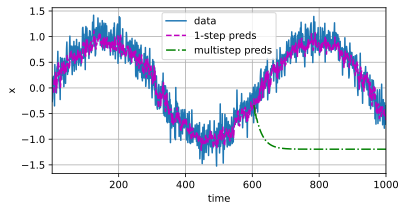

In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

上面的例子所示，绿线的预测显然并不理想。 经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。 为什么这个算法效果这么差呢？事实是由于错误的累积： 假设在步骤1之后，我们积累了一些错误 $\epsilon _1 = \overline{\epsilon}$。 于是，步骤2的输入被扰动了 $\epsilon _1$，结果积累的误差是依照次序的 $\epsilon _2 = \overline{\epsilon} + c\epsilon _1$，其中c为某个常数，后面的预测误差依此类推。 
因此误差可能会相当快地偏离真实的观测结果。
例如，未来24小时的天气预报往往相当准确，但超过这一点，精度就会迅速下降。

基于k=1,4,16,64，通过对整个序列预测的计算， 让我们更仔细地看一下k步预测的困难。

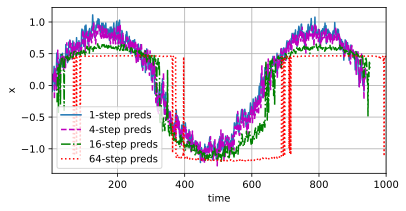

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))  # 特征矩阵
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1），填充后面的列
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。

序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。

对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。

对于直到时间步t的观测序列，其在时间步t+k的预测输出是“k步预测”。随着我们对预测时间k值的增加，会造成误差的快速累积和预测质量的极速下降